# Brain tumor segmentation

U-Net

unet  output → (H, W, 4)

Each pixel has probabilities for 4 classes:
0: No tumor, 1: Glioma, 2: Meningioma, 3: Pituitary

Argmax per pixel → (H, W) mask with values 0, 1, 2, or 3

Find class from mask:

Count how many pixels belong to each class

The class with the most pixels (ignoring background/no tumor) is the predicted tumor type for the image



0 (No tumor): 1,000,000 pixels  
1 (Glioma):    120,000 pixels  
2 (Meningioma): 0  
3 (Pituitary):  0  


Image-level predicted class = Glioma

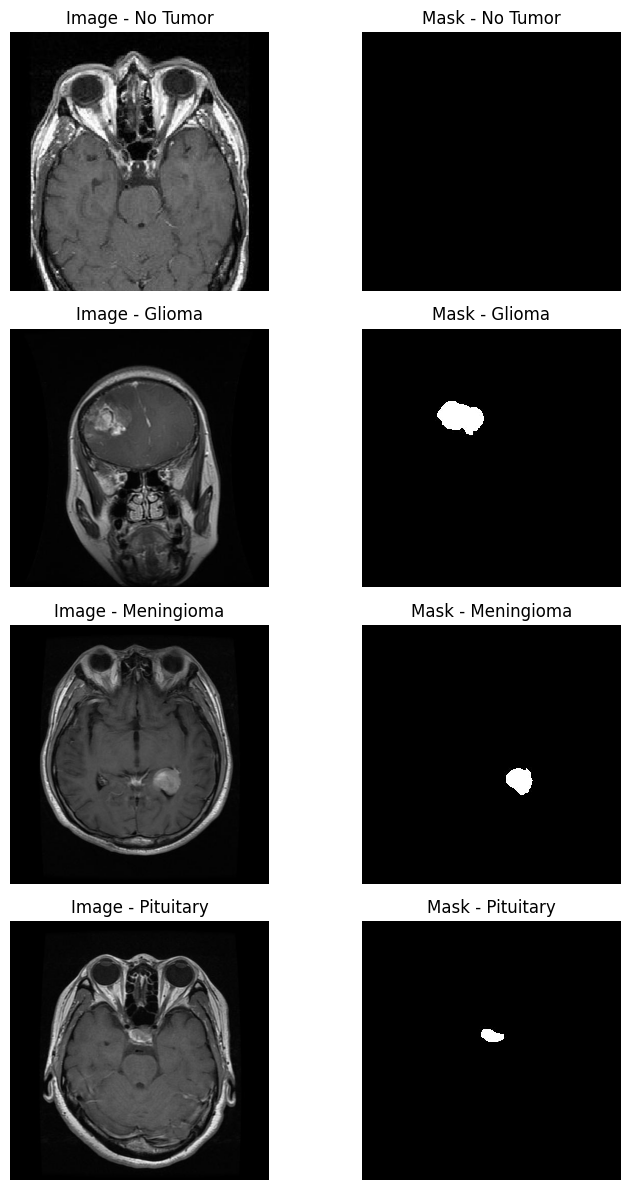

In [29]:
import os
import cv2
import matplotlib.pyplot as plt

# Main folders
image_root = r"D:\brain tumor segmentation\dataset\Brain Tumor Segmentation Dataset\image"
mask_root  = r"D:\brain tumor segmentation\dataset\Brain Tumor Segmentation Dataset\mask"

# Class folders and names
class_folders = ["0", "1", "2", "3"]
class_names = ["No Tumor", "Glioma", "Meningioma", "Pituitary"]

examples = []

for folder, name in zip(class_folders, class_names):
    img_folder = os.path.join(image_root, folder)
    mask_folder = os.path.join(mask_root, folder)
    
    # Get all jpg files
    img_files = [f for f in os.listdir(img_folder) if f.endswith(".jpg")]
    mask_files = [f for f in os.listdir(mask_folder) if f.endswith(".jpg")]
    
    if not img_files or not mask_files:
        print(f"No images or masks in folder {folder}")
        continue
    
    # Pick the first image and its corresponding mask (_m)
    img_path = os.path.join(img_folder, img_files[0])
    base_name = os.path.splitext(img_files[0])[0]
    mask_name = base_name + "_m.jpg"
    mask_path = os.path.join(mask_folder, mask_name)
    
    # Load
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    
    if img is None or mask is None:
        print(f"Could not load {img_path} or {mask_path}")
        continue
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    examples.append((img, mask, name))

# Plot
fig, axes = plt.subplots(len(examples), 2, figsize=(8, 12))

for i, (img, mask, name) in enumerate(examples):
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Image - {name}")
    axes[i, 0].axis("off")
    
    axes[i, 1].imshow(mask, cmap="jet", interpolation="nearest")
    axes[i, 1].set_title(f"Mask - {name}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


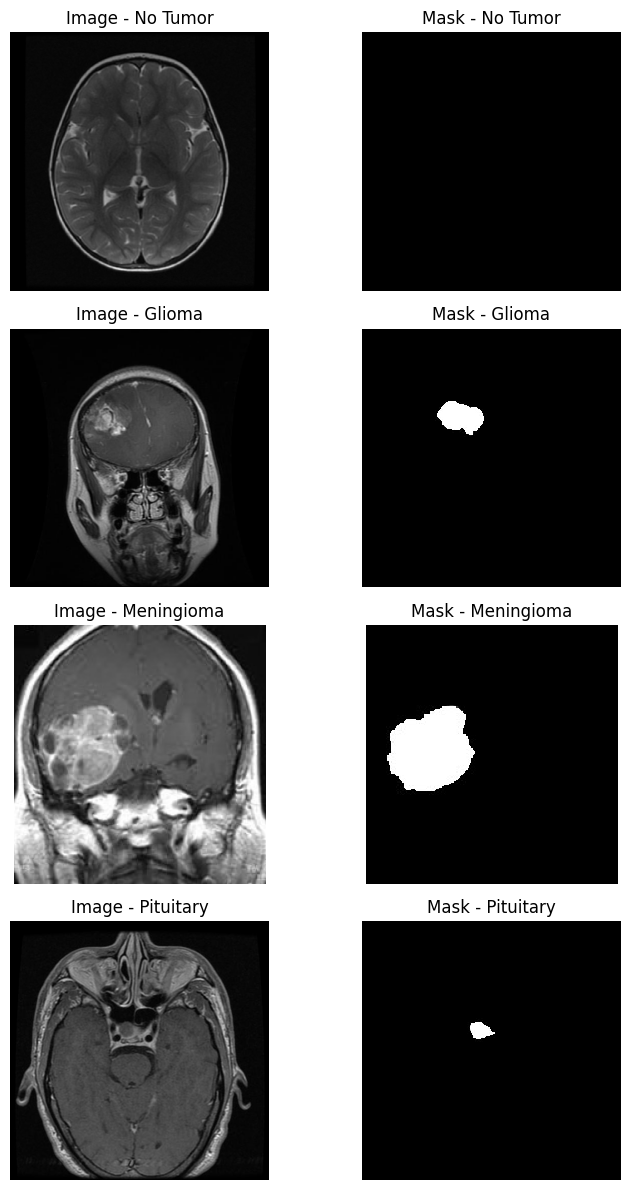

In [30]:
import os
import cv2
import matplotlib.pyplot as plt
import random

# Main folders
image_root = r"D:\brain tumor segmentation\dataset\Brain Tumor Segmentation Dataset\image"
mask_root  = r"D:\brain tumor segmentation\dataset\Brain Tumor Segmentation Dataset\mask"

# Class folders and names
class_folders = ["0", "1", "2", "3"]
class_names = ["No Tumor", "Glioma", "Meningioma", "Pituitary"]

examples = []

for folder, name in zip(class_folders, class_names):
    img_folder = os.path.join(image_root, folder)
    mask_folder = os.path.join(mask_root, folder)
    
    # Get all jpg files
    img_files = [f for f in os.listdir(img_folder) if f.endswith(".jpg")]
    mask_files = [f for f in os.listdir(mask_folder) if f.endswith(".jpg")]
    
    if not img_files or not mask_files:
        print(f"No images or masks in folder {folder}")
        continue
    
    # Pick a random image
    img_file = random.choice(img_files)
    img_path = os.path.join(img_folder, img_file)
    
    # Corresponding mask (_m)
    base_name = os.path.splitext(img_file)[0]
    mask_name = base_name + "_m.jpg"
    mask_path = os.path.join(mask_folder, mask_name)
    
    # Load
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    
    if img is None or mask is None:
        print(f"Could not load {img_path} or {mask_path}")
        continue
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    examples.append((img, mask, name))

# Plot
fig, axes = plt.subplots(len(examples), 2, figsize=(8, 12))

for i, (img, mask, name) in enumerate(examples):
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Image - {name}")
    axes[i, 0].axis("off")
    
    axes[i, 1].imshow(mask, cmap="jet", interpolation="nearest")
    axes[i, 1].set_title(f"Mask - {name}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


In [3]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

# Paths
image_root = r"D:\brain tumor segmentation\dataset\Brain Tumor Segmentation Dataset\image"
mask_root  = r"D:\brain tumor segmentation\dataset\Brain Tumor Segmentation Dataset\mask"

class_folders = ["0", "1", "2", "3"]
img_size = 128
max_images_per_class = 250

images = []
masks = []

for folder in class_folders:
    img_folder = os.path.join(image_root, folder)
    mask_folder = os.path.join(mask_root, folder)
    
    img_files = [f for f in os.listdir(img_folder) if f.endswith(".jpg")][:max_images_per_class]
    
    for img_file in img_files:
        img_path = os.path.join(img_folder, img_file)
        base_name = os.path.splitext(img_file)[0]
        mask_path = os.path.join(mask_folder, base_name + "_m.jpg")
        
        # Load
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        
        if img is None or mask is None:
            continue
        
        # Resize both
        img = cv2.resize(img, (img_size, img_size))
        mask = cv2.resize(mask, (img_size, img_size), interpolation=cv2.INTER_NEAREST)
        
        # Normalize image
        img = img / 255.0
        
        # Ensure mask values 0-3
        mask = mask.astype(np.int32)
        mask = np.clip(mask, 0, 3)
        
        # One-hot encode mask to shape (img_size, img_size, 4)
        mask = to_categorical(mask, num_classes=4)
        
        # Confirm mask shape
        if mask.shape != (img_size, img_size, 4):
            continue
        
        images.append(img)
        masks.append(mask)

# Convert to numpy arrays
X = np.stack(images, axis=0).astype(np.float32)
Y = np.stack(masks, axis=0).astype(np.float32)

print("Images shape:", X.shape)
print("Masks shape:", Y.shape)


Images shape: (187, 128, 128, 3)
Masks shape: (187, 128, 128, 4)


In [4]:
print("Total images:", X.shape[0])
print("Total masks:", Y.shape[0])


Total images: 187
Total masks: 187


In [6]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical

# Paths
image_root = r"D:\brain tumor segmentation\dataset\Brain Tumor Segmentation Dataset\image"
mask_root  = r"D:\brain tumor segmentation\dataset\Brain Tumor Segmentation Dataset\mask"

class_folders = ["0", "1", "2", "3"]
class_names = ["No Tumor", "Glioma", "Meningioma", "Pituitary"]
img_size = 128
max_images_per_class = 250

images = []
masks = []

for folder, cname in zip(class_folders, class_names):
    img_folder = os.path.join(image_root, folder)
    mask_folder = os.path.join(mask_root, folder)
    
    img_files = [f for f in os.listdir(img_folder) if f.endswith(".jpg")]
    loaded_count = 0
    
    for img_file in img_files:
        if loaded_count >= max_images_per_class:
            break
        
        img_path = os.path.join(img_folder, img_file)
        base_name = os.path.splitext(img_file)[0]
        mask_name = base_name + "_m.jpg"
        mask_path = os.path.join(mask_folder, mask_name)
        
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        
        if img is None:
            print(f"⚠ Could not load image: {img_path}")
            continue
        if mask is None:
            print(f"⚠ Could not load mask: {mask_path}")
            continue
        
        # Resize image
        img = cv2.resize(img, (img_size, img_size))
        img = img / 255.0
        
        # Resize mask with nearest interpolation
        mask = cv2.resize(mask, (img_size, img_size), interpolation=cv2.INTER_NEAREST)
        
        # Ensure mask is 2D
        if mask.ndim == 3:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        
        # Clip mask values
        mask = np.clip(mask, 0, 3).astype(np.int32)
        
        # One-hot encode mask
        mask = to_categorical(mask, num_classes=4)
        
        # Confirm mask shape
        if mask.shape != (img_size, img_size, 4):
            print(f"⚠ Skipping mask with wrong shape: {mask_path}, shape: {mask.shape}")
            continue
        
        images.append(img)
        masks.append(mask)
        loaded_count += 1
    
    print(f"Loaded {loaded_count} images for class {cname}")

# Stack into numpy arrays
X = np.stack(images, axis=0).astype(np.float32)
Y = np.stack(masks, axis=0).astype(np.float32)

print("Total images:", X.shape[0])
print("Total masks:", Y.shape[0])



Loaded 250 images for class No Tumor
Loaded 250 images for class Glioma
Loaded 250 images for class Meningioma
Loaded 250 images for class Pituitary
Total images: 1000
Total masks: 1000


In [7]:
X.shape

(1000, 128, 128, 3)

In [9]:
Y.shape

(1000, 128, 128, 4)

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# 1. Train/Validation split
# ---------------------------
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
print("Training samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])


Training samples: 800
Validation samples: 200


In [16]:
# ---------------------------
# 2. U-Net model
# ---------------------------
def unet(input_shape=(128,128,3), num_classes=4):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D(2)(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c7)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# ---------------------------
# 3. Compile model
# ---------------------------
import tensorflow as tf
from tensorflow.keras import backend as K

num_classes = 4

# ---------------------------
# Dice coefficient
# ---------------------------
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# For multi-class: average Dice over classes
def dice_coef_multiclass(y_true, y_pred, smooth=1e-6):
    dice = 0
    for i in range(num_classes):
        dice += dice_coef(y_true[:,:,:,i], y_pred[:,:,:,i])
    return dice / num_classes

# ---------------------------
# Intersection over Union (IoU)
# ---------------------------
def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def iou_multiclass(y_true, y_pred, smooth=1e-6):
    iou = 0
    for i in range(num_classes):
        iou += iou_coef(y_true[:,:,:,i], y_pred[:,:,:,i])
    return iou / num_classes



# ---------------------------
# Dice Loss
# ---------------------------
def dice_loss(y_true, y_pred):
    return 1 - dice_coef_multiclass(y_true, y_pred)

# ---------------------------
# Combined Loss: Categorical Cross-Entropy + Dice Loss
# ---------------------------
def combined_loss(y_true, y_pred):
    cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return cce + d_loss


# Compile model with combined loss
# ---------------------------
model = unet(input_shape=(128,128,3), num_classes=4)
model.compile(
    optimizer='adam',
    loss=combined_loss,
    metrics=['accuracy', dice_coef_multiclass,iou_multiclass]
)









model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_45 (Conv2D)          (None, 128, 128, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 conv2d_46 (Conv2D)          (None, 128, 128, 64)         36928     ['conv2d_45[0][0]']           
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 64)           0         ['conv2d_46[0][0]']           
 g2D)                                                                                       

metrics=['accuracy'] is pixel-wise accuracy.

For each pixel, the predicted class (after softmax) is compared to the true class in the mask.

Example:

Suppose a mask is 128×128, so total pixels = 16,384.
If 14,000 pixels are predicted correctly, the accuracy = 14,000 / 16,384 ≈ 85.4%.

So, the accuracy here is not “image classification accuracy”, it’s how many pixels the model predicted correctly across all masks.






Intersection over Union (IoU)

Definition: Measures the overlap between predicted mask and ground truth mask for a class.

Formula for one class:

iou=tp/tp+fp+fn


Where:

TP = True Positive pixels (correctly predicted as class)

FP = False Positive pixels (predicted as class but not in ground truth)

FN = False Negative pixels (missed pixels of that class)

Range: 0 to 1 (1 means perfect overlap)

Can compute per-class IoU, then average → Mean IoU




Dice Coefficient (F1 Score for masks)

Definition: Measures similarity between predicted and ground truth masks.

Formula:
Deic=2* tp/2*tp+fp+fn


Dice is similar to IoU but gives more weight to overlapping regions.

Often used in medical image segmentation because it handles small objects better.

Range: 0 to 1 (1 = perfect overlap)




Each pixel is treated as a separate “sample” belonging to a class.

TP, FP, FN are counted for pixels, not whole images.

Then you can aggregate per class across the whole dataset or batch




insted of cors entoepy we can use dio loss of dies loos+cress entry
Combined Loss=α⋅CCE+β⋅Dice Loss

Dice Loss=1−Dice Coefficient




here accuyr high but other paramters low why?


In your brain tumor masks:

Most pixels are background (No Tumor).

Only a small fraction are tumor pixels.

So even if the model predicts all pixels as background, accuracy can still be very high (~98%)



Dice coefficient and IoU focus on overlap for each class, not just overall pixel correctness.

If tumor pixels are small:

Missing or mispredicting a few pixels dramatically lowers Dice and IoU, even though overall accuracy looks great.


Interpretation: The model is predicting most background pixels correctly, but struggling to segment tumors accurately yet.


np.argmax(pred_mask, axis=-1) gives the predicted class per pixel:

Pixel with [0.95,0.02,0.02,0.01] → argmax = 0 → background.

Pixel with [0.1,0.7,0.1,0.1] → argmax = 1 → Glioma

This is why background pixels dominate predictions, because most pixels in MRI slices are backgroun

In [17]:
# ---------------------------
# Train model
# ---------------------------
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=16,
    epochs=15
)

Epoch 1/15
50/50 [==============================] - 440s 9s/step - loss: 0.9442 - accuracy: 0.9763 - dice_coef_multiclass: 0.2440 - iou_multiclass: 0.2323 - val_loss: 0.8099 - val_accuracy: 0.9846 - val_dice_coef_multiclass: 0.2620 - val_iou_multiclass: 0.2491
Epoch 2/15
50/50 [==============================] - 442s 9s/step - loss: 0.8020 - accuracy: 0.9849 - dice_coef_multiclass: 0.2684 - iou_multiclass: 0.2539 - val_loss: 0.8080 - val_accuracy: 0.9846 - val_dice_coef_multiclass: 0.2645 - val_iou_multiclass: 0.2536
Epoch 3/15
50/50 [==============================] - 467s 9s/step - loss: 0.7909 - accuracy: 0.9822 - dice_coef_multiclass: 0.2786 - iou_multiclass: 0.2601 - val_loss: 0.8152 - val_accuracy: 0.9845 - val_dice_coef_multiclass: 0.2584 - val_iou_multiclass: 0.2509
Epoch 4/15
50/50 [==============================] - 414s 8s/step - loss: 0.7882 - accuracy: 0.9799 - dice_coef_multiclass: 0.2841 - iou_multiclass: 0.2630 - val_loss: 0.7815 - val_accuracy: 0.9825 - val_dice_coef_mult

In [18]:
model.save("brain_tumor_unet.h5")


c:\Users\USER\miniconda3\envs\Arjun\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 1s/step


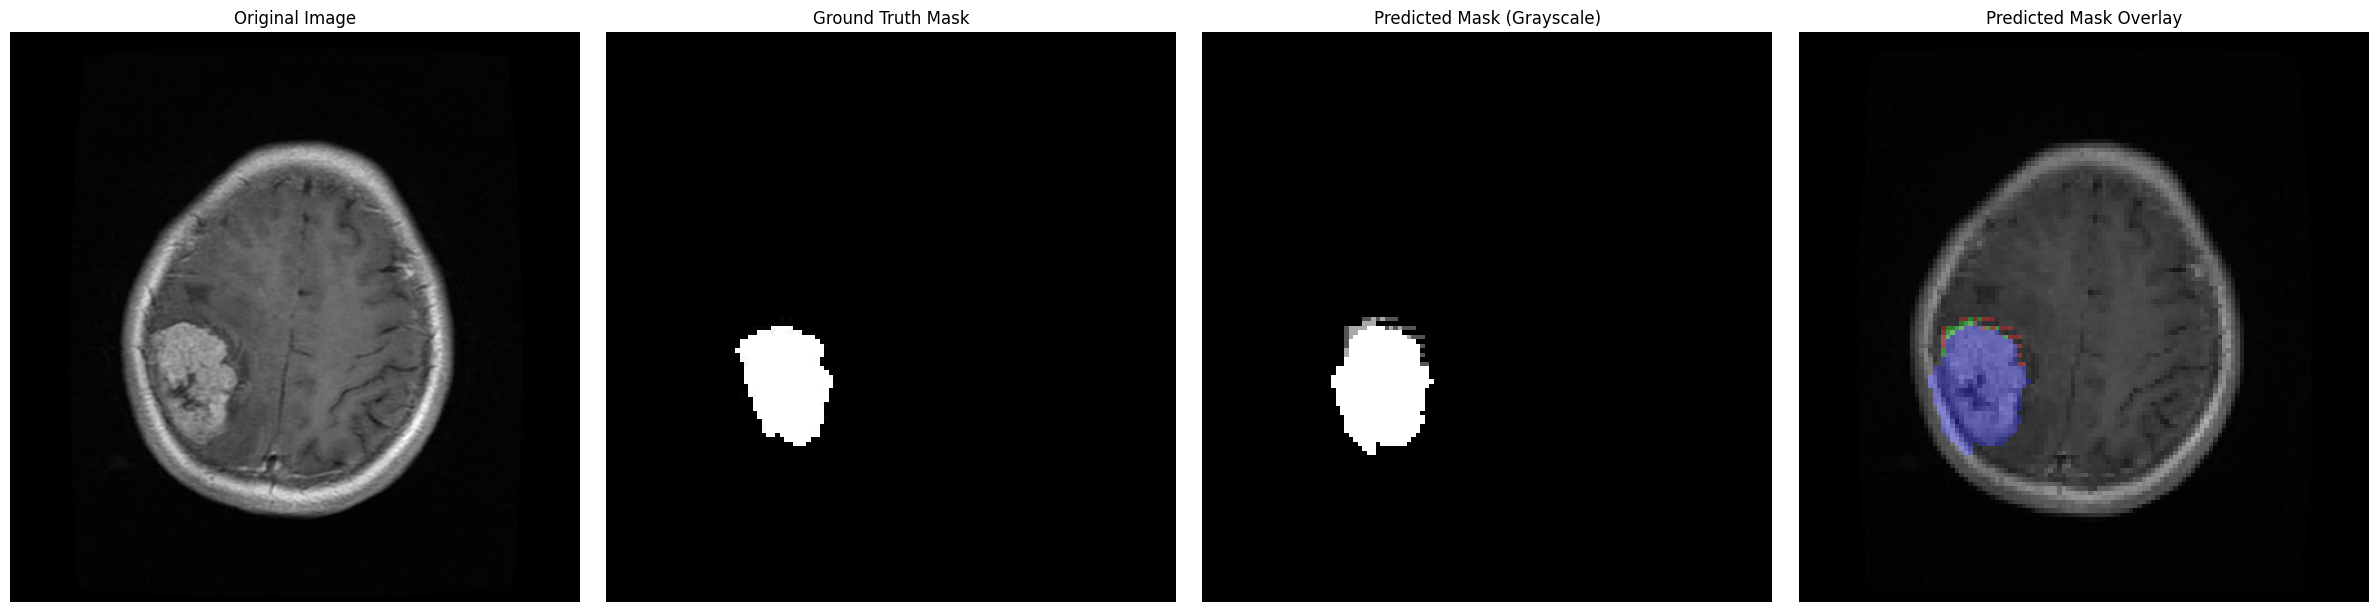

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# ---------------------------
# Load trained model
# ---------------------------
model = load_model("brain_tumor_unet.h5", compile=False)

# ---------------------------
# Colormap for overlay
# ---------------------------
colors = [
    [0,0,0],       # Background - black
    [255,0,0],     # Glioma - red
    [0,255,0],     # Meningioma - green
    [0,0,255]      # Pituitary - blue
]

# ---------------------------
# Load image and ground truth mask
# ---------------------------
image_path = r"D:\brain tumor segmentation\dataset\Brain Tumor Segmentation Dataset\image\2\Tr-me_0011.jpg"
mask_path  = r"D:\brain tumor segmentation\dataset\Brain Tumor Segmentation Dataset\mask\2\Tr-me_0011_m.jpg"

# Load original image
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (128,128))

# Load ground truth mask
gt_mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
gt_mask_resized = cv2.resize(gt_mask, (128,128), interpolation=cv2.INTER_NEAREST)

# ---------------------------
# Preprocess for prediction
# ---------------------------
img_input = img_resized / 255.0
img_input = np.expand_dims(img_input, axis=0)  # shape (1,128,128,3)

# ---------------------------
# Predict mask
# ---------------------------
pred_mask = model.predict(img_input)[0]  # shape (128,128,4)
pred_mask_class = np.argmax(pred_mask, axis=-1)  # pixel-wise class

# ---------------------------
# Create colored overlay
# ---------------------------
colored_mask = np.zeros((128,128,3), dtype=np.uint8)
for i, color in enumerate(colors):
    colored_mask[pred_mask_class == i] = color

overlay = cv2.addWeighted(img_resized, 0.7, colored_mask, 0.3, 0)

# ---------------------------
# Create grayscale predicted mask (0-3)
# ---------------------------
grayscale_mask = pred_mask_class  # Already 0,1,2,3
grayscale_mask_display = (grayscale_mask * (255 // 3)).astype(np.uint8)  # scale 0-255

# ---------------------------
# Plot results (no class names)
# ---------------------------
fig, axes = plt.subplots(1,4, figsize=(24,6))

axes[0].imshow(img_rgb)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(gt_mask_resized, cmap="jet", interpolation="nearest")
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

axes[2].imshow(grayscale_mask_display, cmap="gray", interpolation="nearest")
axes[2].set_title("Predicted Mask (Grayscale)")
axes[2].axis("off")

axes[3].imshow(overlay)
axes[3].set_title("Predicted Mask Overlay")
axes[3].axis("off")



plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 427ms/step


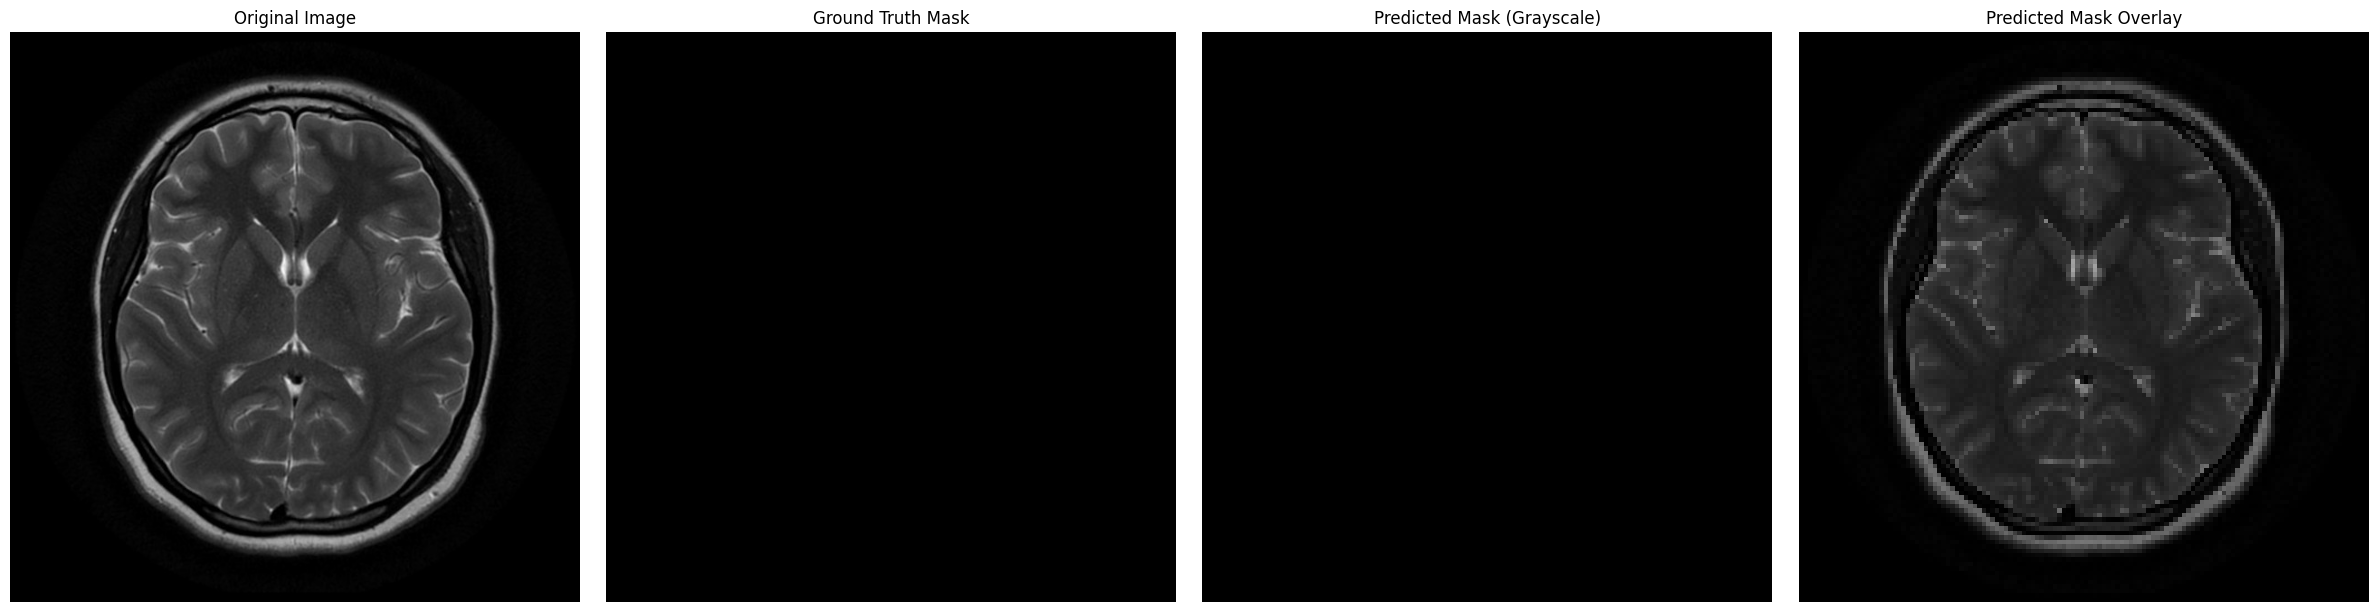

In [29]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# ---------------------------
# Load trained model
# ---------------------------
model = load_model("brain_tumor_unet.h5", compile=False)

# ---------------------------
# Colormap for overlay
# ---------------------------
colors = [
    [0,0,0],       # Background - black
    [255,0,0],     # Glioma - red
    [0,255,0],     # Meningioma - green
    [0,0,255]      # Pituitary - blue
]

# ---------------------------
# Load image and ground truth mask
# ---------------------------
image_path = r"D:\brain tumor segmentation\dataset\Brain Tumor Segmentation Dataset\image\0\Tr-no_0011.jpg"
mask_path  = r"D:\brain tumor segmentation\dataset\Brain Tumor Segmentation Dataset\mask\0\Tr-no_0011_m.jpg"
# Load original image
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (128,128))

# Load ground truth mask
gt_mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
gt_mask_resized = cv2.resize(gt_mask, (128,128), interpolation=cv2.INTER_NEAREST)

# ---------------------------
# Preprocess for prediction
# ---------------------------
img_input = img_resized / 255.0
img_input = np.expand_dims(img_input, axis=0)  # shape (1,128,128,3)

# ---------------------------
# Predict mask
# ---------------------------
pred_mask = model.predict(img_input)[0]  # shape (128,128,4)
pred_mask_class = np.argmax(pred_mask, axis=-1)  # pixel-wise class

# ---------------------------
# Create colored overlay
# ---------------------------
colored_mask = np.zeros((128,128,3), dtype=np.uint8)
for i, color in enumerate(colors):
    colored_mask[pred_mask_class == i] = color

overlay = cv2.addWeighted(img_resized, 0.7, colored_mask, 0.3, 0)

# ---------------------------
# Create grayscale predicted mask (0-3)
# ---------------------------
grayscale_mask = pred_mask_class  # Already 0,1,2,3
grayscale_mask_display = (grayscale_mask * (255 // 3)).astype(np.uint8)  # scale 0-255

# ---------------------------
# Plot results (no class names)
# ---------------------------
fig, axes = plt.subplots(1,4, figsize=(24,6))

axes[0].imshow(img_rgb)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(gt_mask_resized, cmap="jet", interpolation="nearest")
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

axes[2].imshow(grayscale_mask_display, cmap="gray", interpolation="nearest")
axes[2].set_title("Predicted Mask (Grayscale)")
axes[2].axis("off")

axes[3].imshow(overlay)
axes[3].set_title("Predicted Mask Overlay")
axes[3].axis("off")



plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 460ms/step


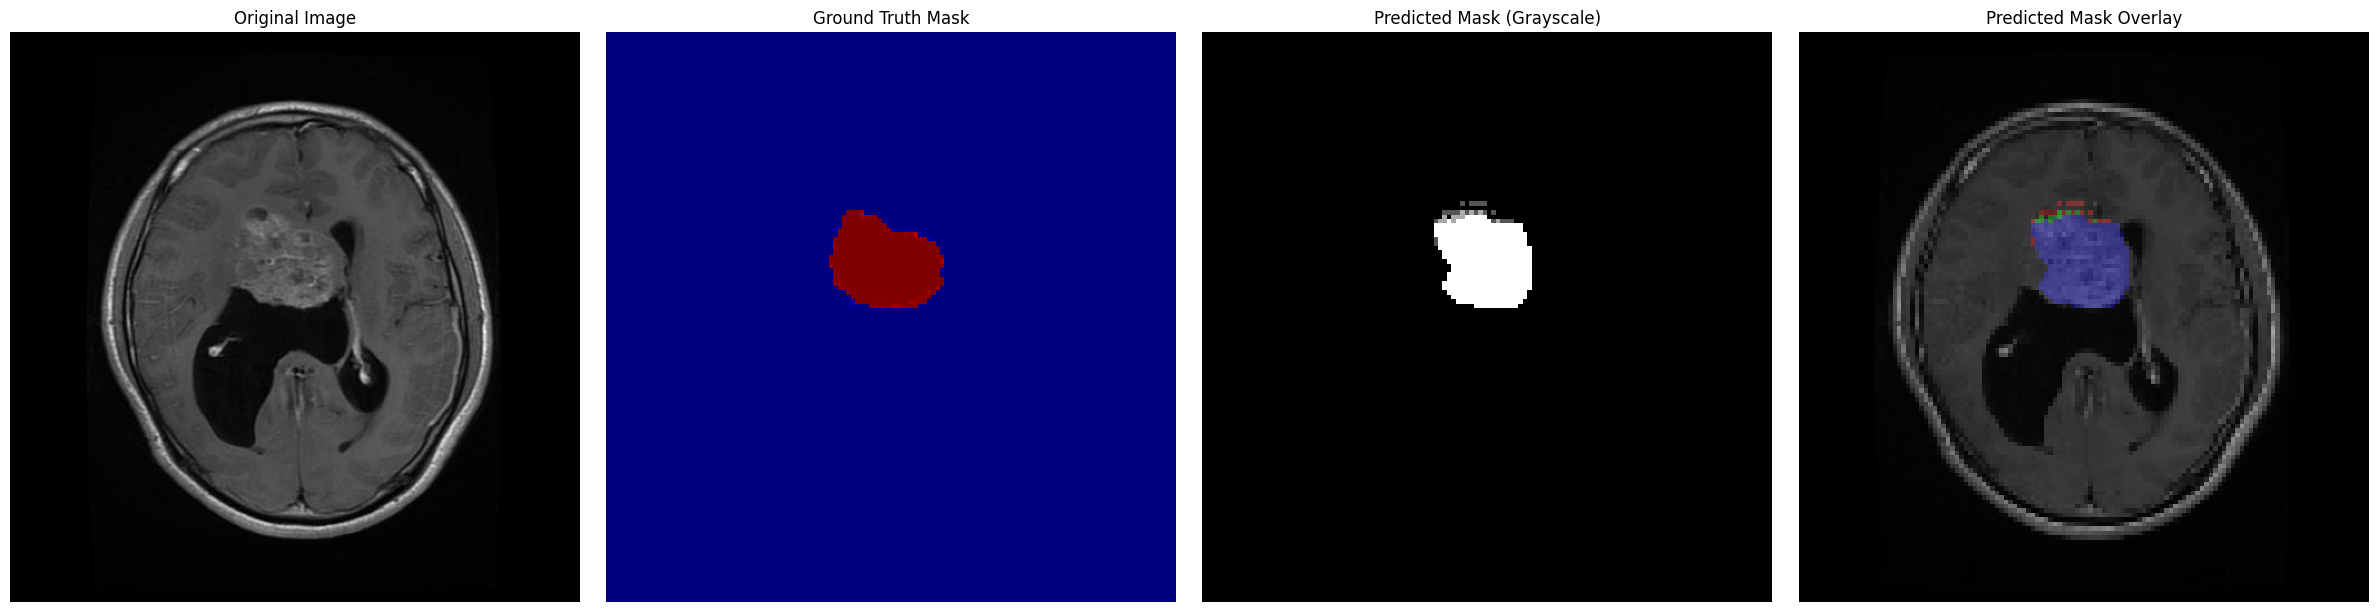

In [30]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# ---------------------------
# Load trained model
# ---------------------------
model = load_model("brain_tumor_unet.h5", compile=False)

# ---------------------------
# Colormap for overlay
# ---------------------------
colors = [
    [0,0,0],       # Background - black
    [255,0,0],     # Glioma - red
    [0,255,0],     # Meningioma - green
    [0,0,255]      # Pituitary - blue
]

# ---------------------------
# Load image and ground truth mask
# ---------------------------
image_path = r"D:\brain tumor segmentation\dataset\Brain Tumor Segmentation Dataset\image\1\Tr-gl_0224.jpg"
mask_path  = r"D:\brain tumor segmentation\dataset\Brain Tumor Segmentation Dataset\mask\1\Tr-gl_0224_m.jpg"

# Load original image
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (128,128))

# Load ground truth mask
gt_mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
gt_mask_resized = cv2.resize(gt_mask, (128,128), interpolation=cv2.INTER_NEAREST)

# ---------------------------
# Preprocess for prediction
# ---------------------------
img_input = img_resized / 255.0
img_input = np.expand_dims(img_input, axis=0)  # shape (1,128,128,3)

# ---------------------------
# Predict mask
# ---------------------------
pred_mask = model.predict(img_input)[0]  # shape (128,128,4)
pred_mask_class = np.argmax(pred_mask, axis=-1)  # pixel-wise class

# ---------------------------
# Create colored overlay
# ---------------------------
colored_mask = np.zeros((128,128,3), dtype=np.uint8)
for i, color in enumerate(colors):
    colored_mask[pred_mask_class == i] = color

overlay = cv2.addWeighted(img_resized, 0.7, colored_mask, 0.3, 0)

# ---------------------------
# Create grayscale predicted mask (0-3)
# ---------------------------
grayscale_mask = pred_mask_class  # Already 0,1,2,3
grayscale_mask_display = (grayscale_mask * (255 // 3)).astype(np.uint8)  # scale 0-255

# ---------------------------
# Plot results (no class names)
# ---------------------------
fig, axes = plt.subplots(1,4, figsize=(24,6))

axes[0].imshow(img_rgb)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(gt_mask_resized, cmap="jet", interpolation="nearest")
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

axes[2].imshow(grayscale_mask_display, cmap="gray", interpolation="nearest")
axes[2].set_title("Predicted Mask (Grayscale)")
axes[2].axis("off")

axes[3].imshow(overlay)
axes[3].set_title("Predicted Mask Overlay")
axes[3].axis("off")



plt.tight_layout()
plt.show()


1/1 [==============================] - 1s 809ms/step


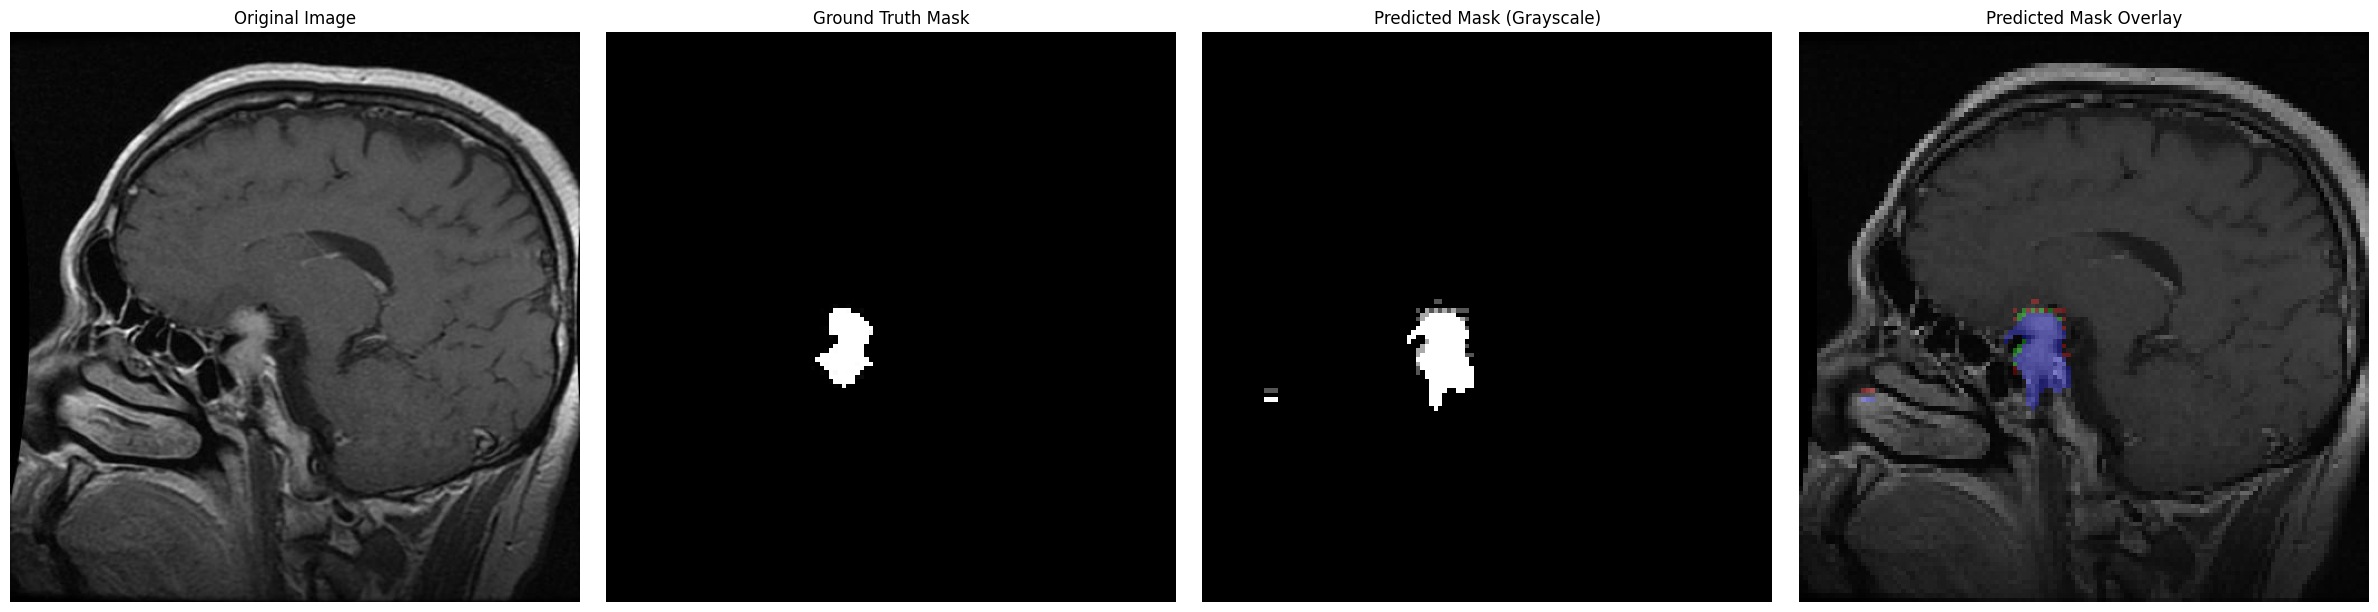

In [33]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# ---------------------------
# Load trained model
# ---------------------------
# ---------------------------
model_path = "brain_tumor_unet.h5"
model= load_model(model_path, compile=False)


# ---------------------------
# Colormap for overlay
# ---------------------------
colors = [
    [0,0,0],       # Background - black
    [255,0,0],     # Glioma - red
    [0,255,0],     # Meningioma - green
    [0,0,255]      # Pituitary - blue
]

# ---------------------------
# Load image and ground truth mask
# ---------------------------
image_path = r"D:\brain tumor segmentation\dataset\Brain Tumor Segmentation Dataset\image\3\Tr-pi_0154.jpg"
mask_path  = r"D:\brain tumor segmentation\dataset\Brain Tumor Segmentation Dataset\mask\3\Tr-pi_0154_m.jpg"

# Load original image
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (128,128))

# Load ground truth mask
gt_mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
gt_mask_resized = cv2.resize(gt_mask, (128,128), interpolation=cv2.INTER_NEAREST)

# ---------------------------
# Preprocess for prediction
# ---------------------------
img_input = img_resized / 255.0
img_input = np.expand_dims(img_input, axis=0)  # shape (1,128,128,3)

# ---------------------------
# Predict mask
# ---------------------------
pred_mask = model.predict(img_input)[0]  # shape (128,128,4)
pred_mask_class = np.argmax(pred_mask, axis=-1)  # pixel-wise class

# ---------------------------
# Create colored overlay
# ---------------------------
colored_mask = np.zeros((128,128,3), dtype=np.uint8)
for i, color in enumerate(colors):
    colored_mask[pred_mask_class == i] = color

overlay = cv2.addWeighted(img_resized, 0.7, colored_mask, 0.3, 0)

# ---------------------------
# Create grayscale predicted mask (0-3)
# ---------------------------
grayscale_mask = pred_mask_class  # Already 0,1,2,3
grayscale_mask_display = (grayscale_mask * (255 // 3)).astype(np.uint8)  # scale 0-255

# ---------------------------
# Plot results (no class names)
# ---------------------------
fig, axes = plt.subplots(1,4, figsize=(24,6))

axes[0].imshow(img_rgb)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(gt_mask_resized, cmap="jet", interpolation="nearest")
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

axes[2].imshow(grayscale_mask_display, cmap="gray", interpolation="nearest")
axes[2].set_title("Predicted Mask (Grayscale)")
axes[2].axis("off")

axes[3].imshow(overlay)
axes[3].set_title("Predicted Mask Overlay")
axes[3].axis("off")



plt.tight_layout()
plt.show()
